In [16]:
import ee
ee.Initialize()
import geemap
import requests
import json
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt

In [17]:
shp=r'D:\Berkeley\CE263N\Project idea\4weixin\Boston\City_of_Boston_Boundary-shp\City_of_Boston_Boundary.shp'
shp=gpd.read_file(shp).to_crs('EPSG:4326')
print(shp.total_bounds.flatten())


[-71.19083563  42.22788727 -70.92346937  42.39693964]


In [18]:
Boston=ee.Geometry.BBox(-71.19083563,  42.22788727, -70.92346937,  42.39693964)

In [19]:
Map=geemap.Map()
Map.setCenter(-71.0589, 42.3601,zoom=15)
Map.add_basemap("HYBRID")
Map

Map(center=[42.3601, -71.0589], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…

# Imagery Datasets

## Sentinel 2

In [20]:
def maskS2clouds(images):
    '''
    function to mask clouds using the Seninel-2 QA band
    input: Sentinel-2 image
    output: cloud masked Sentinel-2 image
    '''
    
    qa = images.select('QA60')

    # bits 10 and 11 are clouds and cirrus
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # both flags set to zero indicates clear conditions.
    clear = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
           qa.bitwiseAnd(cirrusBitMask).eq(0))
    
    # clouds is not clear
    cloud = clear.Not().rename(['ESA_clouds'])

    # return the masked and scaled data.
    return images.addBands(cloud)

In [21]:
S2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(Boston) \
    .filterDate('2018-05-01', '2018-06-30') \
    .sort('CLOUDY_PIXEL_PERCENTAGE') \
    .min() \
    .select(['B2', 'B3', 'B4', 'B8', 'B9','B11','B12']) \
    .divide(10000)

In [22]:
S2.getInfo

<bound method Image.getInfo of <ee.image.Image object at 0x0000020827798448>>

In [23]:
S2.select('B2').getInfo()

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'float',
    'min': 0,
    'max': 6.553500175476074},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [24]:
blue=S2.select('B2')
nir = S2.select('B8')
red = S2.select('B4')

In [25]:
# EVI = 2.5 * (B08 - B04) / ((B08 + 6.0 * B04 - 7.5 * B02) + 1.0);
numerator = nir.subtract(red).multiply(ee.Number(2.5))
denominator = nir.add(red.multiply(ee.Number(6))).subtract(blue.multiply(ee.Number(7.5))).add(ee.Number(1))
evi=numerator.divide(denominator).rename('EVI')

In [26]:
Map.addLayer(evi,{'min': 0, 'max': 2, 'palette': ['#006a4e', '#b8d5cd','#bbbbbb']},'evi')
Map

Map(center=[42.3601, -71.0589], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…

## Training Labels

In [27]:
trees = ee.Geometry.MultiPolygon(
       [[[[-71.03082067294578, 42.37169954575853],
           [-71.03082067294578, 42.371566779445146],
           [-71.03056049867133, 42.371566779445146],
           [-71.03056049867133, 42.37169954575853]]],
         [[[-71.00674394273165, 42.391940147878366],
           [-71.00674394273165, 42.391757900584295],
           [-71.0062128653467, 42.391757900584295],
           [-71.0062128653467, 42.391940147878366]]],
         [[[-71.00661519669893, 42.393269348550945],
           [-71.00661519669893, 42.39306333419471],
           [-71.00632015370729, 42.39306333419471],
           [-71.00632015370729, 42.393269348550945]]],
         [[[-71.0095292387111, 42.39366249589521],
           [-71.0095292387111, 42.39351789064098],
           [-71.0091349539859, 42.39351789064098],
           [-71.0091349539859, 42.39366249589521]]],
         [[[-71.01205677060791, 42.391470334379754],
           [-71.01205677060791, 42.391038483439615],
           [-71.01132720975586, 42.391038483439615],
           [-71.01132720975586, 42.391470334379754]]],
         [[[-71.03445717994482, 42.3823753219603],
           [-71.03445717994482, 42.38225644697826],
           [-71.03417823020727, 42.38225644697826],
           [-71.03417823020727, 42.3823753219603]]]], 'EPSG:4326', False)
grass = ee.Geometry.MultiPolygon(
    [[[[-71.02154638671959, 42.37672460434733],
           [-71.02154638671959, 42.37607469321432],
           [-71.02024819755638, 42.37607469321432],
           [-71.02024819755638, 42.37672460434733]]],
         [[[-71.02622415924156, 42.38737584776482],
           [-71.02622415924156, 42.38695585527513],
           [-71.02571990394677, 42.38695585527513],
           [-71.02571990394677, 42.38737584776482]]],
         [[[-70.99804449763825, 42.39521773822059],
           [-70.99804449763825, 42.39452047777895],
           [-70.99699307170441, 42.39452047777895],
           [-70.99699307170441, 42.39521773822059]]],
         [[[-70.99169302669098, 42.39440954926715],
           [-70.99169302669098, 42.394045068490804],
           [-70.9913711616092, 42.394045068490804],
           [-70.9913711616092, 42.39440954926715]]],
         [[[-70.99276285067846, 42.395265323845464],
           [-70.99276285067846, 42.39519401352819],
           [-70.99267165557195, 42.39519401352819],
           [-70.99267165557195, 42.395265323845464]]],
         [[[-71.01992787414622, 42.39886513907054],
           [-71.01992787414622, 42.3986195283929],
           [-71.01948799186778, 42.3986195283929],
           [-71.01948799186778, 42.39886513907054]]]],'EPSG:4326',False)
nongreens = ee.Geometry.MultiPolygon(
        [[[[-71.0266065745933, 42.3907515551849],
           [-71.0266065745933, 42.39056930443964],
           [-71.02617742115092, 42.39056930443964],
           [-71.02617742115092, 42.3907515551849]]],
         [[[-71.02804960304331, 42.39459850721831],
           [-71.02804960304331, 42.39397255168308],
           [-71.02607549720835, 42.39397255168308],
           [-71.02607549720835, 42.39459850721831]]],
         [[[-71.04311759817736, 42.39690080636235],
           [-71.04311759817736, 42.39520522773044],
           [-71.04172284948962, 42.39520522773044],
           [-71.04172284948962, 42.39690080636235]]],
         [[[-71.04648645270007, 42.395332001549185],
           [-71.04648645270007, 42.39434949775564],
           [-71.04498441565173, 42.39434949775564],
           [-71.04498441565173, 42.395332001549185]]],
         [[[-71.06264407980578, 42.38877112014429],
           [-71.06264407980578, 42.38693268254578],
           [-71.05474765646593, 42.38693268254578],
           [-71.05474765646593, 42.38877112014429]]],
         [[[-71.09251315939562, 42.4014485340243],
           [-71.09251315939562, 42.39954708520123],
           [-71.09096820700304, 42.39954708520123],
           [-71.09096820700304, 42.4014485340243]]]],'EPSG:4326', False);

## Classification

In [28]:
#Convert geometry to Feature Collection (class must be numeric)
classes = ee.FeatureCollection([
  ee.Feature(trees, {'class': 0}),  
  ee.Feature(grass, {'class': 1}),
  ee.Feature(nongreens,{'class':2})
])


#bands for training
bands=S2.bandNames()

In [29]:
# Hyperparameters tuning
sample=S2.sampleRegions(classes, ['class'], 10)
sample=sample.randomColumn()
train=sample.filter(ee.Filter.lt('random',0.3))
test=sample.filter(ee.Filter.gte('random',0.5))

In [30]:
numTrees=range(10,30,1)
accuracies=[]
for i in numTrees:
    classifier=ee.Classifier.smileRandomForest(i).train(train,'class',bands)
    accuracy=test.classify(classifier).errorMatrix('class','classification').accuracy()
    accuracies.append(accuracy.getInfo())
    

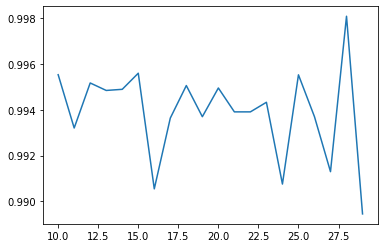

In [31]:
plt.plot(numTrees, accuracies)

In [ ]:
#geemap.ee_export_image_to_drive(classified, description='bostonTrees', folder='export', region=Boston, scale=1)

## LS8 EVI

In [33]:
LS = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_EVI') \
    .filterDate('2017-01-01', '2017-12-31') \
    .filterBounds(Boston)

## NAIP

In [34]:
naip = ee.ImageCollection('USDA/NAIP/DOQQ') \
        .filter(ee.Filter.date('2018-01-01', '2018-12-31')) \
        .filterBounds(Boston) \
        .min() \
        .select(['R','G','B','N'])

    

In [35]:
nir = naip.select('N');
red = naip.select('R');
naip_ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI');


In [36]:


training = naip.sampleRegions(classes, ['class'], 10)


# Train a CART classifier with default parameters.
#bands=['B2','B3','B4','B8','NDVI','B11','B12']
bands=naip.bandNames()
trained = ee.Classifier.smileRandomForest(15).train(training, 'class', bands)





In [37]:
# Classify the image with the same bands used for training.
classified = naip.select(bands).classify(trained)


In [38]:
# Display classified region
Map.setCenter(-71.0589, 42.3601,zoom=12)
Map.addLayer(classified, {'min': 0, 'max': 2, 'palette': ['#006a4e', '#b8d5cd','#bbbbbb']}, "classification")
#Map.addLayer(imageCollection, vis_params, 'LA Sentinel-2',opacity=0.5)
Map

Map(center=[42.3601, -71.0589], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButt…

In [40]:
vector=classified.reduceToVectors()

In [41]:
classified.getInfo()

{'type': 'Image',
 'bands': [{'id': 'classification',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -2147483648,
    'max': 2147483647},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [42]:
naip_ndvi.getInfo()

{'type': 'Image',
 'bands': [{'id': 'NDVI',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [43]:
naip=naip.addBands(naip_ndvi)

In [44]:
naipVis = {
  min: 0.0,
  max: 255.0,
}

In [45]:
ndvi_vis={
    'min':0,
    'max':1,
    #'bands':['NDVI'],
    'palette': ['grey','white', 'green']
}


In [ ]:
#Map.addLayer(naip, naipVis, 'naip')
Map.addLayer(naip_ndvi,ndvi_vis,'naip ndvi')
Map

## Training Labels

In [ ]:
trees = ee.Geometry.MultiPolygon(
       [[[[-71.03082067294578, 42.37169954575853],
           [-71.03082067294578, 42.371566779445146],
           [-71.03056049867133, 42.371566779445146],
           [-71.03056049867133, 42.37169954575853]]],
         [[[-71.00674394273165, 42.391940147878366],
           [-71.00674394273165, 42.391757900584295],
           [-71.0062128653467, 42.391757900584295],
           [-71.0062128653467, 42.391940147878366]]],
         [[[-71.00661519669893, 42.393269348550945],
           [-71.00661519669893, 42.39306333419471],
           [-71.00632015370729, 42.39306333419471],
           [-71.00632015370729, 42.393269348550945]]],
         [[[-71.0095292387111, 42.39366249589521],
           [-71.0095292387111, 42.39351789064098],
           [-71.0091349539859, 42.39351789064098],
           [-71.0091349539859, 42.39366249589521]]],
         [[[-71.01205677060791, 42.391470334379754],
           [-71.01205677060791, 42.391038483439615],
           [-71.01132720975586, 42.391038483439615],
           [-71.01132720975586, 42.391470334379754]]],
         [[[-71.03445717994482, 42.3823753219603],
           [-71.03445717994482, 42.38225644697826],
           [-71.03417823020727, 42.38225644697826],
           [-71.03417823020727, 42.3823753219603]]]], 'EPSG:4326', False)
grass = ee.Geometry.MultiPolygon(
    [[[[-71.02154638671959, 42.37672460434733],
           [-71.02154638671959, 42.37607469321432],
           [-71.02024819755638, 42.37607469321432],
           [-71.02024819755638, 42.37672460434733]]],
         [[[-71.02622415924156, 42.38737584776482],
           [-71.02622415924156, 42.38695585527513],
           [-71.02571990394677, 42.38695585527513],
           [-71.02571990394677, 42.38737584776482]]],
         [[[-70.99804449763825, 42.39521773822059],
           [-70.99804449763825, 42.39452047777895],
           [-70.99699307170441, 42.39452047777895],
           [-70.99699307170441, 42.39521773822059]]],
         [[[-70.99169302669098, 42.39440954926715],
           [-70.99169302669098, 42.394045068490804],
           [-70.9913711616092, 42.394045068490804],
           [-70.9913711616092, 42.39440954926715]]],
         [[[-70.99276285067846, 42.395265323845464],
           [-70.99276285067846, 42.39519401352819],
           [-70.99267165557195, 42.39519401352819],
           [-70.99267165557195, 42.395265323845464]]],
         [[[-71.01992787414622, 42.39886513907054],
           [-71.01992787414622, 42.3986195283929],
           [-71.01948799186778, 42.3986195283929],
           [-71.01948799186778, 42.39886513907054]]]],'EPSG:4326',False)
nongreens = ee.Geometry.MultiPolygon(
        [[[[-71.0266065745933, 42.3907515551849],
           [-71.0266065745933, 42.39056930443964],
           [-71.02617742115092, 42.39056930443964],
           [-71.02617742115092, 42.3907515551849]]],
         [[[-71.02804960304331, 42.39459850721831],
           [-71.02804960304331, 42.39397255168308],
           [-71.02607549720835, 42.39397255168308],
           [-71.02607549720835, 42.39459850721831]]],
         [[[-71.04311759817736, 42.39690080636235],
           [-71.04311759817736, 42.39520522773044],
           [-71.04172284948962, 42.39520522773044],
           [-71.04172284948962, 42.39690080636235]]],
         [[[-71.04648645270007, 42.395332001549185],
           [-71.04648645270007, 42.39434949775564],
           [-71.04498441565173, 42.39434949775564],
           [-71.04498441565173, 42.395332001549185]]],
         [[[-71.06264407980578, 42.38877112014429],
           [-71.06264407980578, 42.38693268254578],
           [-71.05474765646593, 42.38693268254578],
           [-71.05474765646593, 42.38877112014429]]],
         [[[-71.09251315939562, 42.4014485340243],
           [-71.09251315939562, 42.39954708520123],
           [-71.09096820700304, 42.39954708520123],
           [-71.09096820700304, 42.4014485340243]]]],'EPSG:4326', False);

## Clustering

## Classification

In [ ]:
#Convert geometry to Feature Collection (class must be numeric)
classes = ee.FeatureCollection([
  ee.Feature(trees, {'class': 0}),  
  ee.Feature(grass, {'class': 1}),
  ee.Feature(nongreens,{'class':2})
  
])





In [ ]:
# Hyperparameters tuning
sample=naip.sampleRegions(classes, ['class'], 10)
sample=sample.randomColumn()
train=sample.filter(ee.Filter.lt('random',0.3))
test=sample.filter(ee.Filter.gte('random',0.5))

In [ ]:
numTrees=range(10,30,5)
accuracies=[]
for i in numTrees:
    classifier=ee.Classifier.smileRandomForest(i).train(training,'class',bands)
    accuracy=test.classify(classifier).errorMatrix('class','classification').accuracy()
    accuracies.append(accuracy.getInfo())
    

In [ ]:
plt.plot(numTrees, accuracies)

In [ ]:
training = naip.sampleRegions(classes, ['class'], 10)
# Train a CART classifier with default parameters.
#bands=['B2','B3','B4','B8','NDVI','B11','B12']
bands=naip.bandNames()
trained = ee.Classifier.smileRandomForest(15).train(training, 'class', bands)


# Classify the image with the same bands used for training.
classified = naip.select(bands).classify(trained)


In [ ]:
# Display classified region
Map.setCenter(-71.0589, 42.3601,zoom=12)
Map.addLayer(classified, {'min': 0, 'max': 2, 'palette': ['#006a4e', '#b8d5cd','#bbbbbb']}, "classification")
#Map.addLayer(imageCollection, vis_params, 'LA Sentinel-2',opacity=0.5)
Map

In [ ]:
naip.getInfo()

In [ ]:
vector=classified.reduceToVectors()

In [ ]:
classified.getInfo()

In [ ]:
#geemap.ee_export_image_to_drive(classified, description='bostonTrees', folder='export', region=Boston, scale=1)